-------------------------------------------------------------

# Exercise 1.1

# Prepping data

In [87]:
# file imports
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from scipy.optimize import minimize as minimize
import time
import random

In [88]:
# splitting data in train test and val set
def data_split(data):
    
    X = np.array(data.iloc[:,:2])
    y = np.array(data.iloc[:, 2])
    
    # train-val split 100% -> 70% - 30%
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=1) 
    
    # val-test split 30% -> 15% - 15%
    X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size=0.5, random_state=1)
    return X_train.T, X_test.T, X_val.T, y_train, y_test, y_val


data = pd.read_excel(r'C:\Users\RE-Giorgio\Downloads\dataPoints.xlsx')
random.seed(1696995)
X_train, X_test, X_val, y_train, y_test, y_val = data_split(data)

# Neural Network parent class

In [89]:
class ShallowNeuralNetwork:
    
    # defines the variables for a shallow nn with scalar output
    def __init__(self, X, y, N, sigma, rho, method):

        self.X = X
        self.y = y
        self.N = N
        self.w = np.random.normal(0,1,(self.N, self.X.shape[0]))
        self.b = np.random.normal(0,1,(self.N,1))
        self.v = np.random.normal(0,1,(1, self.N))
        self.output = np.zeros(y.shape[0])
        self.rho = rho
        self.sigma = sigma
        self.method = method

    # separates the previously concatenated arguments
    def separate(self, l):
        
        shapes = [(self.N, self.X.shape[0]), (self.N, 1), (1, self.N)]
        sliced = np.split(l, np.cumsum([shapes[i][0]*shapes[i][1] for i in range(3)]))
        w, b, v = [np.array(sliced[i]).reshape(shapes[i]) for i in range(3)]
        return w, b, v
    
    # objective function to minimize
    def loss(self,params):
        
        w, b, v = self.separate(params)
        return 0.5 * np.mean(np.square((self.predict(self.X, w, b, v) - self.y))) +\
            self.rho*np.square(np.linalg.norm(params))
    
    # metric for train and test accuracy
    def mse(self, X, y, w, b, v):
        return 0.5*np.mean(np.square(self.predict(X, w, b, v) - y)) 

## MLP child class

In [90]:
# Mlp inherits the general charectiristics of a shallow nn 
class Mlp(ShallowNeuralNetwork):
    
    # activation function (hyperbolic tangent)
    def g(self, x):
        return (1-np.exp(-2*x*self.sigma))/(1+np.exp(-2*x*self.sigma))

    # forward propagation
    def predict(self, x, w, b, v):
        
        a = np.dot(w, x) - b
        z = self.g(a)
        self.output = np.dot(v, z)
        return self.output
    
    """
    there's a mistake here somewhere... 
    
    # derivative of activation function
    def g_der(self, x):
        return (4*self.sigma*np.exp(2*self.sigma*x))/np.square(np.exp(2*self.sigma*x)+1)
    
    def grad(self, params):
        
        w, b, v = self.separate(params)
        a = np.dot(w, self.X) - b
        f_x = self.predict(self.X, w, b, v)

        dw = 2*self.rho*w + (1/self.X.shape[1]) * (np.dot(np.dot(v.T, (f_x-y_train)) * self.g_der(a), self.X.T))
        db = 2*self.rho*b + (1/self.X.shape[1]) * (np.dot(v.T, (f_x-y_train) ) * self.g_der(a))
        db = np.sum(db, axis = 1, keepdims = True)
        dv = 2*self.rho*v + (1/self.X.shape[1]) * (np.dot((f_x-y_train), (self.g(a)).T))

        return np.concatenate([array.reshape(-1) for array in [dw, db, dv]])
    """
    
    
                          
    # optimization of the objective function
    def optimize(self):
        
        inits = np.concatenate([array.reshape(-1) for array in [self.w, self.b, self.v]])
        
        print("begin training...", "\n")
        start = time.time()
        
        """
        to use the manual gradient put jac = self.grad and check if train error is still 0.001392
        """
        result =  minimize(self.loss, x0 = inits, method = self.method)
        time_elapsed = time.time() - start
        print(result)
        print("finished training.")
        
        self.w, self.b, self.v = self.separate(result.x)
        
        func_eval = result.nfev
        grad_eval = result.njev
        iterations = result.nit
        opt_fun = result.fun
        return func_eval, grad_eval, iterations, opt_fun, time_elapsed

## first run

In [91]:
nn = Mlp(X_train, y_train, N = 18, sigma = 2, rho = 10e-5, method = "CG")
func_eval, grad_eval, iterations, opt_fun, time_elapsed = nn.optimize()
print("Training Error :", nn.mse(X_train, y_train, nn.w, nn.b, nn.v))

begin training... 

     fun: 0.011430685849582923
     jac: array([ 5.08350786e-06,  4.26080078e-08,  2.23447569e-06, -1.15716830e-07,
       -8.51927325e-07, -3.48896720e-07,  4.34508547e-06, -1.40129123e-06,
       -1.96218025e-06,  9.10833478e-07,  1.59663614e-06, -1.15786679e-06,
       -1.94041058e-06,  8.84989277e-07,  2.01526564e-06, -1.04517676e-06,
       -2.12341547e-06,  1.35938171e-06,  2.49280129e-06,  3.59723344e-08,
        1.73796434e-06, -3.49350739e-06,  1.06333755e-06,  9.84873623e-08,
        3.28558963e-06, -8.40635039e-07,  9.96864401e-07,  5.37955202e-07,
        2.12853774e-06, -1.35938171e-06,  7.52147753e-06,  4.65079211e-07,
        1.67009421e-06,  2.12807208e-07, -1.59931369e-06,  1.20291952e-06,
       -1.03190541e-06,  4.10666689e-06,  9.06991772e-07,  7.21216202e-06,
        2.21887603e-06,  5.39945904e-06,  4.44403850e-06, -2.25997064e-06,
        1.02247577e-06, -5.61552588e-06, -1.80548523e-06, -1.57137401e-06,
        5.29200770e-06,  5.21889888e-07

In [363]:
def plot(nn):
    
    # creates 3d space
    fig = plt.figure()
    ax = Axes3D(fig)
    
    # grid of the support of the estimated function
    x1 = np.linspace(1, -1, 200)
    x2 = np.linspace(-2, 2, 200)
    X1, X2 = np.meshgrid(x1, x2)
    
    # predictions on the given support
    Y = np.array([nn.predict(np.array([x1[i], x2[k]]).reshape(2,1),
                             nn.w, nn.b, nn.v) for i in range(200) for k in range(200)])
    Y = Y.ravel().reshape(200,200)
    
    # plotting
    ax.plot_surface(X1, X2, Y, rstride=1, cstride=1,cmap='viridis', edgecolor='none')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.show()

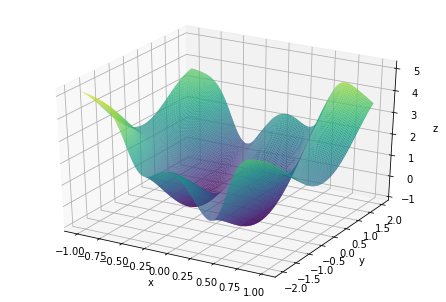

In [364]:
plot(nn)

In [55]:
# trials for the graddient....
N = 20
w = np.random.normal(0,1,(N, 2))
b = np.random.normal(0,1,(N, 1))
v = np.random.normal(0,1,(1, N))
# activation function
def g(x):
    return (1-np.exp(-2*x))/(1+np.exp(-2*x)) 
def sech(x):
    return np.square(2/(np.exp(x) - np.exp(-x)))
    
a = np.dot(w, X_train) - b
z = g(a)
f_x = np.dot(v, z)
rho = 10e-5

dw =  (1/X_train.shape[1]) * np.dot(np.dot(v.T, f_x-y_train + 2*rho*np.sum(w))* (1-np.square(g(a))), X_train.T)
dv = 2*rho*v + (1/X_train.shape[1]) * np.dot(f_x-y_train, g(a).T)
db = 2*rho*b + (1/X_train.shape[1]) * np.dot(v.T, f_x-y_train)* np.square(sech(a))
db = np.sum(db, axis = 1, keepdims = True)
#boh2 = 2*rho*v + np.mean((f_x - y_train) * g(a))

In [63]:
np.dot(v.T, f_x-y_train + 2*rho*np.sum(w)) @ (1-np.square(g(a)))

(20, 210)

------------------------------------

# Exercise 2.1